In [3]:
import numpy as np
import cv2
import os
# from PIL import Image
import matplotlib.pyplot as plt
import csv

Турецкие строчные буквы - abcçdefgğhiıjklmnoöprsştüvyz 

In [4]:
class FeatureExtractor:
    def __init__(self):
        pass
    
    def show(self, im):
        plt.imshow(im)
        plt.axis('off') 
        plt.show()

    def calc_raw_moment(self,img,x1=0,x2=-1,y1=0,y2=-1,p=0,q=0):
        if y2<0:
            y2=img.shape[0]
        if x2<0:
            x2=img.shape[1]
        rm = 0
        for y in range(y1,y2):
            for x in range(x1,x2):
                rm += x**p * y**q * img[x,y]
        return rm

    def calc_weight(self, img,x1,x2,y1,y2):
        return self.calc_raw_moment(img,x1,x2,y1,y2,0,0)
    
    def calc_rel_weight(self, img,x1,x2,y1,y2):
        h = x2-x1
        w = y2-y1
        return self.calc_raw_moment(img,x1,x2,y1,y2,0,0) / (h*w)
    
    def calc_center(self,img):
        H, W = img.shape[0], img.shape[1]
        weight = self.calc_raw_moment(img,0,H,0,W)
        return [self.calc_raw_moment(img,0,H,0,W,1,0)/weight,
                self.calc_raw_moment(img,0,H,0,W,0,1)/weight]

    def calc_inertia_moment(self,img):
        xc,yc = self.calc_center(img)
        xim = 0
        yim = 0
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                xim += (y - yc) ** 2 * img[x, y]
                yim += (x - xc) ** 2 * img[x, y]
        return [xim,yim]
    
    def calc_rel_inertia_moment(self,img):
        im = self.calc_inertia_moment(img)
        return im / (img.shape[0]**2 * img.shape[1]**2)

    def get_features(self,image):
        _, img = cv2.threshold(image, 100, 1, cv2.THRESH_BINARY_INV)
        H, W = img.shape[0], img.shape[1]
        areas = [(H//2) * (W//2),   (H//2)*(W-W//2), 
                 (H-H//2) * (W//2), (H-H//2) * (W-W//2)]
        weights = [self.calc_weight(img, 0, H//2, 0, W//2), 
                   self.calc_weight(img, 0, H//2, W//2, W),
                   self.calc_weight(img, H//2, H, 0, W//2),
                   self.calc_weight(img, H//2, H, W//2, W),]
        weight = self.calc_weight(img, 0, H, 0, W)
        weights_rel = [weights[0]/areas[0],
                       weights[1]/areas[1],
                       weights[2]/areas[2],
                       weights[3]/areas[3]]
        weight_rel = weight / (H*W)
        center = self.calc_center(img)
        center_rel = [(center[0]-1)/(H-1), (center[1]-1)/(W-1)]
        inertia = self.calc_inertia_moment(img)
        inertia_rel = np.divide(inertia, H**2 * W**2)

        features = {
            "weight": weight,
            "rel_weight": weight_rel,
            "weights" : weights,
            "rel_weights" : weights_rel,
            "center" : center,
            "center_norm" : center_rel,
            "inertia_hor" : inertia[0],
            "inertia_vert" : inertia[1],
            "inertia_hor_norm" : inertia_rel[0],
            "inertia_vert_norm" : inertia_rel[1],
        }

        return features

In [18]:
class Classification:
    def __init__(self, output_path, csv_path):
        self.output_path = output_path
        self.csv_path = csv_path

    def euclidean_distance(self, v1, v2):
        v1 = np.array(v1, dtype=np.float32)
        v2 = np.array(v2, dtype=np.float32)
        
        distance = np.sqrt(np.sum((v1 - v2)**2))
        return distance
    
    def get_coords(self, profile):
        left = None
        sym = []
        for i in range(len(profile)):
            if profile[i] > 0 and left is None:
                left = i
            elif profile[i] == 0 and left is not None:
                sym.append((left, i))
                left = None
        if left is not None:
            sym.append((left, len(profile)))
        return sym

    def get_segments(self, image):
        _, img = cv2.threshold(image, 100, 1, cv2.THRESH_BINARY_INV)
        H, W = img.shape[0], img.shape[1]
        print(H,W)

        V_profile = np.sum(img, axis=0)

        sym = self.get_coords(V_profile)

        boxes = []
        for s in sym:
            s_profile = np.sum(img[:,s[0]:s[1]], axis=1)
            coords = self.get_coords(s_profile)
            start, end = coords[0][0], coords[-1][-1]
            boxes.append((s[0], start, s[1], end))

        w = (boxes[0][2]-boxes[0][0])/2
        spaces = []
        for i in range(len(boxes)-1):
            if (boxes[i+1][0] - boxes[i][2]) > w:
                spaces.append(i)
    
        return spaces, boxes
        
    def draw_segments(self):
        for name, img in self.data.items():
            boxes = self.get_segments(img,name)
            rgb_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            for b in boxes:
                cv2.rectangle(rgb_img,(b[0],b[1]),(b[2],b[3]),(0,255,0),1)
            filename = os.path.join(self.output_path, name)
            cv2.imwrite(filename, rgb_img)

    def save_csv(self, dist, name):
        filename = os.path.join(self.output_path, name+".csv")
        with open(filename, 'w') as f: 
            id = 0
            w = csv.writer(f)
            for sym in dist:
                data = [id]
                data.extend(sym)
                w.writerow(data)
                id+=1

    def get_symbols(self, image, name):
        spaces, boxes = self.get_segments(image)
        syms = {}
        for filename in os.listdir(self.csv_path):
            if filename.endswith('csv'):
                data = {}
                path = os.path.join(self.csv_path, filename)
                with open(path, 'r') as file:
                    reader = csv.reader(file)
                    header = next(reader) 
                    content = next(reader)  
                    
                    for key, value in zip(header, content):
                        data[key] = value
                syms[filename[:-4]] = data

        agent = FeatureExtractor()
        sentence = {}
        id = 0
        for b in boxes:
            img = image[b[1]:b[3],b[0]:b[2]]
            f = agent.get_features(img)
            sentence[id] = f
            id+=1

        distances = []
        for _, l in sentence.items():
            line = []
            for letter, s in syms.items():
                v1 = [l['rel_weight'], l['center_norm'][0], l['center_norm'][1], l['inertia_hor_norm'], l['inertia_vert_norm']]
                v2 = [s['rel_weight'], s['center_norm'][1:-1].split(",")[0], s['center_norm'][1:-1].split(",")[1], s['inertia_hor_norm'], s['inertia_vert_norm']]
                dist = self.euclidean_distance(v1,v2)
                line.append((letter,dist))
            maxdist = max(l[1] for l in line)
            prox = [(x[0],1-x[1]/maxdist) for x in line]
            prox.sort(key=lambda x: x[1], reverse=True)
            distances.append(prox)

        self.save_csv(distances, name)

        return spaces, distances

In [20]:
agent = Classification( "./output", "./input/csv")
im = cv2.imread('./input/gray_byron_orig.bmp', cv2.IMREAD_GRAYSCALE)
spaces, dist = agent.get_symbols(im,'gray_byron_orig')

332 9574


In [21]:
dist[0]

[('g', 0.9635982103645802),
 ('o', 0.9622351266443729),
 ('s', 0.9607423841953278),
 ('z', 0.9527043253183365),
 ('ğ', 0.9487796686589718),
 ('e', 0.9341964945197105),
 ('t', 0.9213654771447182),
 ('ö', 0.9163720980286598),
 ('h', 0.9161309972405434),
 ('n', 0.9080658555030823),
 ('ş', 0.9074360206723213),
 ('ü', 0.9005026370286942),
 ('b', 0.900222435593605),
 ('c', 0.8907252475619316),
 ('m', 0.8873843401670456),
 ('v', 0.8858337998390198),
 ('a', 0.8842291086912155),
 ('ç', 0.8761637881398201),
 ('d', 0.8735093027353287),
 ('p', 0.8590559363365173),
 ('y', 0.8471681028604507),
 ('f', 0.8374198526144028),
 (',', 0.8256691992282867),
 ('k', 0.8202211856842041),
 ('r', 0.7295481264591217),
 ('j', 0.7226499915122986),
 ('i', 0.46077847480773926),
 ('ı', 0.33487653732299805),
 ('l', 0.0)]

In [22]:
sentence = ("a d a m ı d a h a a z s e v m i y o r u m , a m a d o ğ a ' y ı d a h a ç o k s e v i y o r u m").split(" ")
print("adamı daha az sevmiyorum, ama doğa'yı daha çok seviyorum")
sum = 0
for i in range(len(dist)):
    print(dist[i][0][0], end="")
    sum += (dist[i][0][0] == sentence[i])
    if i in spaces:
        print(" ", end="")
print("\n", sum/len(dist))

adamı daha az sevmiyorum, ama doğa'yı daha çok seviyorum
gdgmı dghg gz oevmiyorom, gmg dozgıyı dgho fok oeviyorsm
 0.6458333333333334


49 1413


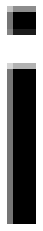

In [24]:
im = cv2.imread('./input/gray_byron.bmp', cv2.IMREAD_GRAYSCALE)
boxes = agent.get_segments(im, 'gray_byron.bmp') 
b = boxes[15]
plt.imshow(im[b[1]:b[3],b[0]:b[2]], cmap='gray')
plt.axis('off') 
plt.show()